In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pandas_datareader import data as web
from datetime import datetime

In [2]:
# We are starting precovid to compare before and after
START = "2019-01-01"
END = datetime.today().strftime("%Y-%m-%d")

In [3]:
# FRED series (monthly, quarterly, annual)
SERIES = {
    "mortgage_rate": "MORTGAGE30US",     # 30-Year Fixed Rate Mortgage Average in the US (%)
    "home_price": "MSPUS",               # Median Sales Price of Houses Sold (Quarterly, $)
    "household_income": "MEHOINUSA672N"  # Median Household Income (Annual, $)
}

In [4]:
# Loan assumptions
TERM_YEARS = 30
N = TERM_YEARS * 12
DOWN_PCT = 0.20  # 20% down
def monthly_payment(price, rate_annual, down=DOWN_PCT, n=N):
    """price ($), rate_annual (%) -> monthly $ payment (principal+interest)."""
    P = price * (1 - down)
    r = (rate_annual / 100) / 12.0
    if r == 0:
        return P / n
    return P * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

In [5]:
# %% Pull data
mort = web.DataReader(SERIES["mortgage_rate"], "fred", START, END)  # monthly %
price_q = web.DataReader(SERIES["home_price"], "fred", START, END)   # quarterly $
inc_a = web.DataReader(SERIES["household_income"], "fred", START, END)  # annual $

mort.columns = ["mortgage_rate"]
price_q.columns = ["home_price"]
inc_a.columns = ["household_income"]

In [6]:
# Align to monthly: forward-fill quarterly/annual to monthly index
idx = mort.index  # monthly index drives the model
price_m = price_q.reindex(idx, method="ffill")
inc_m = inc_a.reindex(idx, method="ffill")

df = pd.concat([mort, price_m, inc_m], axis=1).dropna()
# Sanity window (in case of leading NaNs)
df = df.loc[df.index.min():]

In [7]:
# %% Baseline payment & affordability
df["loan_amount"] = df["home_price"] * (1 - DOWN_PCT)
df["monthly_payment_baseline"] = df.apply(
    lambda r: monthly_payment(r["home_price"], r["mortgage_rate"]), axis=1
)

In [8]:
# Convert annual income to monthly for affordability ratio
df["income_monthly"] = df["household_income"] / 12.0
df["affordability_pct"] = 100 * (df["monthly_payment_baseline"] / df["income_monthly"])

# %% Scenarios: +1% and -1% rate
for shift, label in [(1.0, "plus_1pct"), (-1.0, "minus_1pct")]:
    rate_shifted = df["mortgage_rate"] + shift
    df[f"monthly_payment_{label}"] = df.apply(
        lambda r: monthly_payment(r["home_price"], r["mortgage_rate"] + shift), axis=1
    )
    df[f"affordability_{label}"] = 100 * (df[f"monthly_payment_{label}"] / df["income_monthly"])

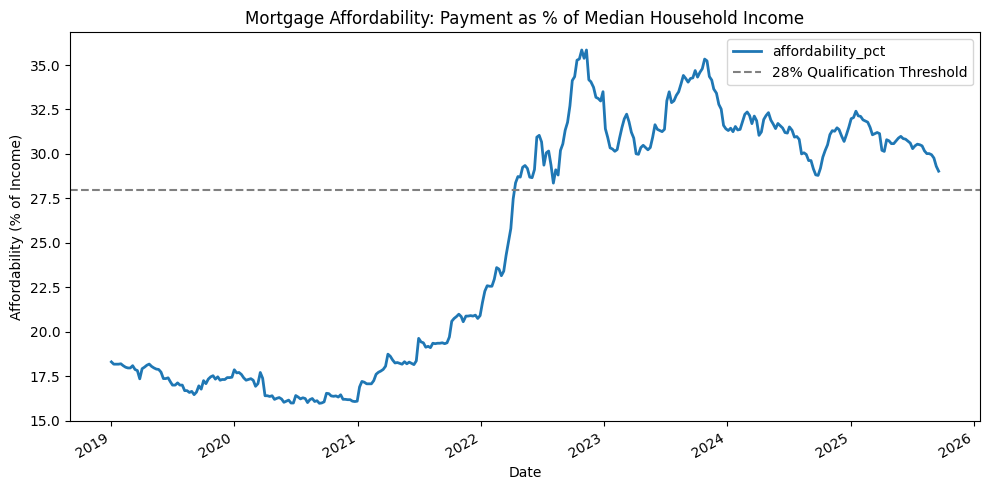

In [9]:
# %% Chart 1: Affordability trend
plt.figure(figsize=(10, 5))
df["affordability_pct"].plot(linewidth=2)  # your affordability line

# Add horizontal 28% threshold
plt.axhline(y=28, color="gray", linestyle="--", linewidth=1.5, label="28% Qualification Threshold")

plt.title("Mortgage Affordability: Payment as % of Median Household Income")
plt.ylabel("Affordability (% of Income)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()


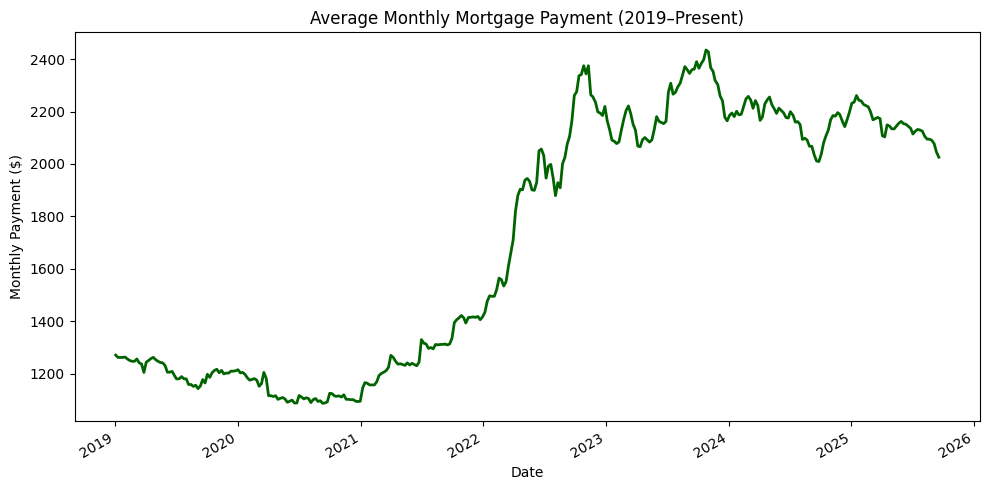

In [10]:
# %% Chart 2: Average Monthly Mortgage Payment (2019–Present)
since2019 = df.loc["2019-01-01":, "monthly_payment_baseline"]

plt.figure(figsize=(10, 5))
since2019.plot(color="darkgreen", linewidth=2)

plt.title("Average Monthly Mortgage Payment (2019–Present)")
plt.ylabel("Monthly Payment ($)")
plt.xlabel("Date")
plt.tight_layout()

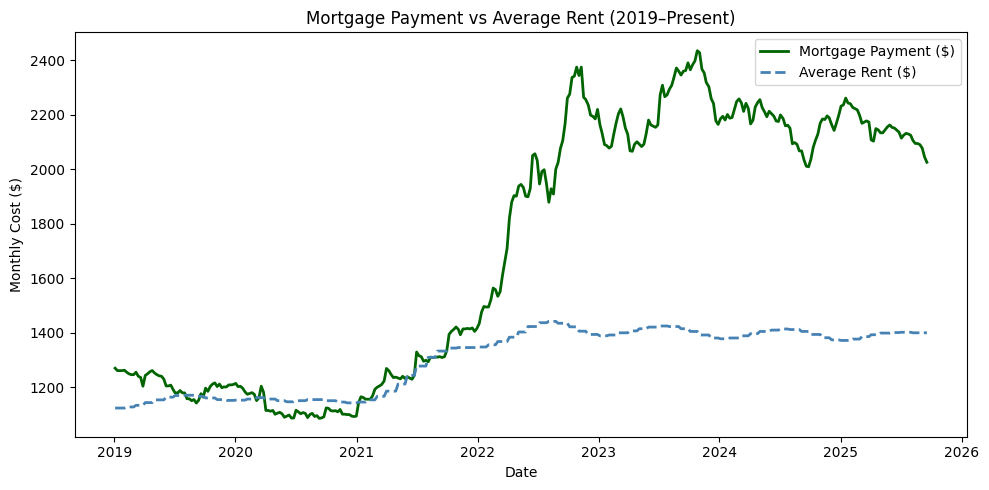

In [12]:
file = "/Users/ndilawari/Documents/Python/Home Affordability/Apartment_List_Rent_Estimates_2025_08.csv"

# Load
raw = pd.read_csv(file)

# Filter: National + overall
national = raw[
    (raw["location_type"].str.lower() == "national") &
    (raw["bed_size"].str.lower() == "overall")
].copy()

# Melt wide YYYY_MM columns into long format
date_cols = [c for c in national.columns if "_" in c and c[:4].isdigit()]
rent_long = national.melt(
    id_vars=["location_name", "location_type", "bed_size"],
    value_vars=date_cols,
    var_name="ym",
    value_name="rent"
)

# Convert YYYY_MM → datetime
rent_long["month"] = pd.to_datetime(rent_long["ym"], format="%Y_%m")
rent_long["rent"] = pd.to_numeric(rent_long["rent"], errors="coerce")

# Final national rent series
us_rent = rent_long[["month", "rent"]].dropna().sort_values("month").set_index("month")
us_rent = us_rent.loc["2019-01-01":]  # filter since 2019

# Align to your mortgage df
aligned_rent = us_rent.reindex(df.index, method="ffill")
mort_since2019 = df.loc["2019-01-01":, "monthly_payment_baseline"]
rent_since2019 = aligned_rent.loc["2019-01-01":, "rent"]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(mort_since2019.index, mort_since2019.values,
         label="Mortgage Payment ($)", linewidth=2, color="darkgreen")
plt.plot(rent_since2019.index, rent_since2019.values,
         label="Average Rent ($)", linewidth=2, linestyle="--", color="steelblue")

plt.title("Mortgage Payment vs Average Rent (2019–Present)")
plt.ylabel("Monthly Cost ($)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()

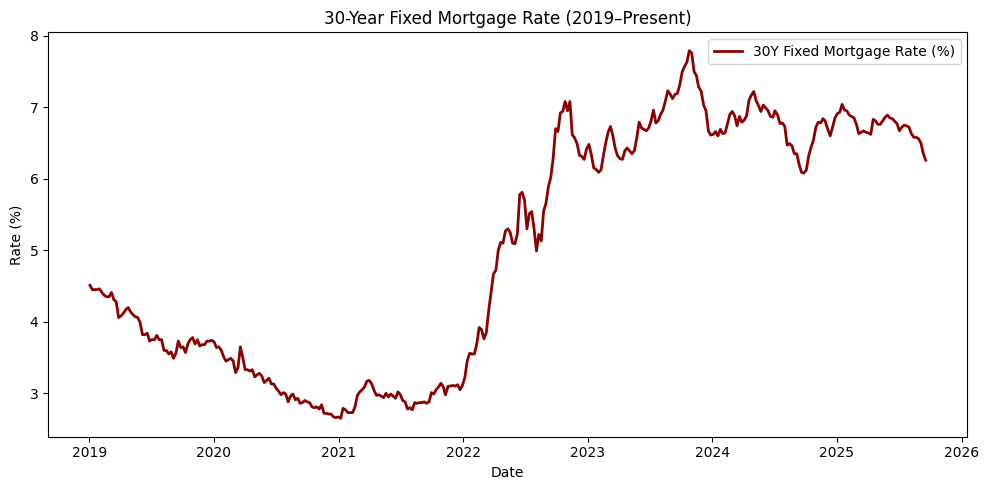

In [13]:
# %% Chart 4: 30-Year Fixed Mortgage Rate (2019–Present)
mort_rate_since2019 = df.loc["2019-01-01":, "mortgage_rate"]

plt.figure(figsize=(10, 5))
plt.plot(mort_rate_since2019.index, mort_rate_since2019.values,
         color="darkred", linewidth=2, label="30Y Fixed Mortgage Rate (%)")

plt.title("30-Year Fixed Mortgage Rate (2019–Present)")
plt.ylabel("Rate (%)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()

/var/folders/yt/553f2tq97psd1r3ctc7cfdxc0000gn/T/ipykernel_77038/523625092.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


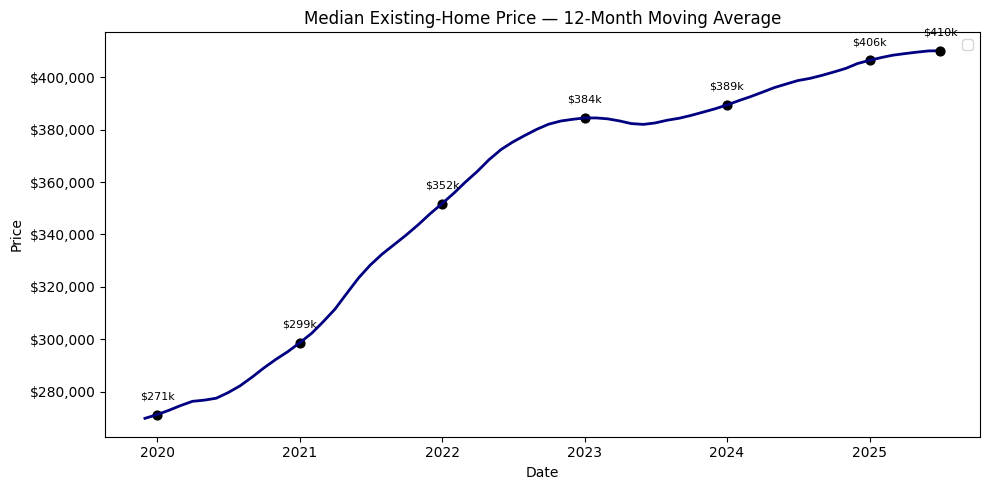

In [15]:
# Path to your Excel file
EXCEL_FILE = "/Users/ndilawari/Documents/Python/Home Affordability/median home prices.xlsx"  
DATE_COL   = "Date"                                             
PRICE_COL  = "Median Home Price"                       

# Load Excel
hp = pd.read_excel(EXCEL_FILE)
hp[DATE_COL] = pd.to_datetime(hp[DATE_COL])
hp = hp.set_index(DATE_COL).sort_index()

# 12-month moving average
hp["price_12m_ma"] = hp[PRICE_COL].rolling(window=12, min_periods=12).mean()
ma = hp["price_12m_ma"].dropna()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(ma.index, ma.values, linewidth=2, color="navy")
plt.title("Median Existing-Home Price — 12-Month Moving Average")
plt.ylabel("Price")
plt.xlabel("Date")

# Format y-axis as currency (no decimals)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# --- Add data labels for Jan of each year ---
for year in range(ma.index[0].year + 1, ma.index[-1].year + 1):
    jan_date = pd.to_datetime(f"{year}-01-01")
    if jan_date in ma.index:
        value = ma.loc[jan_date]
        label_val = round(value, -3)  # round to nearest 1000
        label_txt = f'${int(label_val/1000)}k'
        plt.scatter(jan_date, value, color="black", s=40)
        plt.text(jan_date, value + 5000, label_txt,  # offset 5k above the line
                 ha="center", va="bottom", fontsize=8)

# --- Add data label for latest point ---
latest_date = ma.index[-1]
latest_value = ma.iloc[-1]
label_val = round(latest_value, -3)
label_txt = f'${int(label_val/1000)}k'
plt.scatter(latest_date, latest_value, color="black", s=40, zorder=5)
plt.text(latest_date, latest_value + 5000, label_txt,
         ha="center", va="bottom", fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()

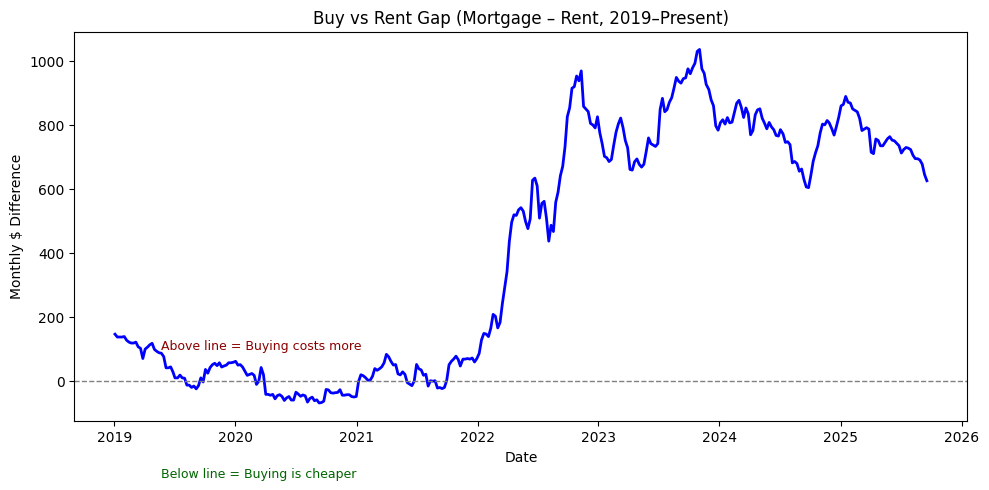

Latest Buy vs Rent Gap: $625/month
Last time buying was even/cheaper: Sep 2021 (gap $-20)
Month with maximum gap (buying most expensive): Nov 2023 (gap $1,035)


In [16]:
# --- Buy vs Rent Gap ($ Difference) ---
gap = (mort_since2019 - rent_since2019).dropna()

plt.figure(figsize=(10,5))
plt.plot(gap.index, gap.values, linewidth=2, color="blue")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.text(gap.index[20], 100, "Above line = Buying costs more", color="darkred", fontsize=9)
plt.text(gap.index[20], -300, "Below line = Buying is cheaper", color="darkgreen", fontsize=9)
plt.title("Buy vs Rent Gap (Mortgage – Rent, 2019–Present)")
plt.ylabel("Monthly $ Difference")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# --- exec-level stats ---
latest_gap = int(gap.iloc[-1])
print(f"Latest Buy vs Rent Gap: ${latest_gap:,}/month")

even_or_cheaper = gap[gap <= 0]
if not even_or_cheaper.empty:
    last_ok_date = even_or_cheaper.index[-1]
    last_ok_val = even_or_cheaper.iloc[-1]
    print(f"Last time buying was even/cheaper: {last_ok_date.strftime('%b %Y')} (gap ${int(last_ok_val):,})")

# Add the month/year where the gap was maximum (buying most expensive vs renting)
if not gap.empty:
    max_gap_date = gap.idxmax()
    max_gap_val  = gap.loc[max_gap_date]
    print(f"Month with maximum gap (buying most expensive): {max_gap_date.strftime('%b %Y')} (gap ${int(max_gap_val):,})")

In [17]:
# Helper: monthly annuity factor (used to scale payment with rate changes)
def annuity_factor(rate_annual_pct, term_years=30):
    r = (rate_annual_pct / 100.0) / 12.0
    n = term_years * 12
    if np.isclose(r, 0.0):
        return 1.0 / n
    return (r * (1 + r)**n) / ((1 + r)**n - 1)

# Use the latest month in your df
latest = df.iloc[-1]
base_payment = float(latest["monthly_payment_baseline"])
base_rate    = float(latest["mortgage_rate"])

# Scale baseline payment by the annuity-factor ratio at ±50 bps (loan amount cancels out)
A0   = annuity_factor(base_rate)
A_dn = annuity_factor(base_rate - 0.5)
A_up = annuity_factor(base_rate + 0.5)

pay_dn50 = base_payment * (A_dn / A0)  # payment if rate drops 50 bps
pay_up50 = base_payment * (A_up / A0)  # payment if rate rises 50 bps

# Dollar deltas (rounded to whole dollars)
save_dn  = base_payment - pay_dn50
incr_up  = pay_up50 - base_payment

# Percent changes
pct_dn = (pay_dn50 / base_payment - 1.0) * 100.0
pct_up = (pay_up50 / base_payment - 1.0) * 100.0

# Pretty print
def fmt_d(x): return f"${x:,.0f}"
def fmt_p(x): return f"{x:+.1f}%"

print("=== ±50 bps Sensitivity ===")
print(f"Current 30Y: {base_rate:.1f}%")
print(f"Current Payment: {fmt_d(base_payment)}")
print()
print(f"If rate -50 bps ({base_rate-0.5:.1f}%): {fmt_d(pay_dn50)}  | Δ {fmt_d(save_dn)}  | {fmt_p(pct_dn)}")
print(f"If rate +50 bps ({base_rate+0.5:.1f}%): {fmt_d(pay_up50)}  | Δ {fmt_d(incr_up)} | {fmt_p(pct_up)}")

=== ±50 bps Sensitivity ===
Current 30Y: 6.3%
Current Payment: $2,026

If rate -50 bps (5.8%): $1,920  | Δ $106  | -5.2%
If rate +50 bps (6.8%): $2,134  | Δ $108 | +5.3%


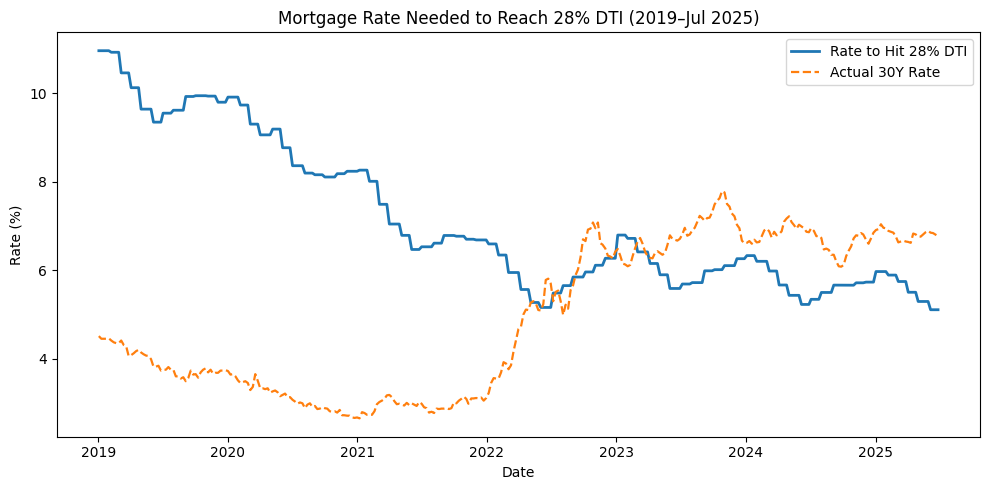

  Actual 30Y rate: 6.77%
  Rate to hit 28% DTI: 5.11%
  Gap: 166 bps


In [ ]:
# ==== 1) Load monthly median home price from Excel ====
EXCEL_FILE = "/Users/ndilawari/Documents/Python/Home Lending/median home prices.xlsx"   # <-- update path
DATE_COL   = "Date"                                        # <-- update if different
PRICE_COL  = "Median Home Price"                  # <-- update if different
CUTOFF     = "2025-07-01"                                  # Excel ends Jul 2025

hp = pd.read_excel(EXCEL_FILE)
hp[DATE_COL] = pd.to_datetime(hp[DATE_COL])
hp = hp[[DATE_COL, PRICE_COL]].sort_values(DATE_COL).set_index(DATE_COL)
hp = hp.loc[:CUTOFF]                                       # stop at Jul 2025

# Ensure df has a DatetimeIndex and cut to Jul 2025 too
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)
df = df.loc[:CUTOFF].copy()

# Merge price from Excel into df (forward-fill in case df has more dates within the month)
df["median_home_price"] = hp.reindex(df.index, method="ffill")[PRICE_COL]

# ==== 2) Make sure income is available monthly ====
if "income_monthly" not in df.columns:
    if "household_income" in df.columns:
        df["income_monthly"] = df["household_income"] / 12.0
    else:
        raise KeyError("Need 'household_income' (annual) or 'income_monthly' in df.")

# ==== 3) Functions to compute payment and the rate that hits a target payment ====
def pmt_from_rate(price, rate_annual, down_pct=0.20, term_years=30):
    L = price * (1 - down_pct)
    r = (rate_annual / 100.0) / 12.0
    n = term_years * 12
    if np.isclose(r, 0.0):
        return L / n
    return L * (r * (1 + r)**n) / ((1 + r)**n - 1)

def solve_rate_for_payment(price, target_payment, down_pct=0.20, term_years=30, lo=0.0, hi=15.0, tol=1e-6):
    # binary search for annual rate that yields target_payment
    for _ in range(60):
        mid = 0.5 * (lo + hi)
        pay = pmt_from_rate(price, mid, down_pct, term_years)
        if pay > target_payment:
            hi = mid
        else:
            lo = mid
        if hi - lo < tol:
            break
    return 0.5 * (lo + hi)

# ==== 4) Compute the "rate to qualify at 28% DTI" each month ====
TARGET_PCT = 0.28
df["qual_rate_28pct"] = df.apply(
    lambda r: solve_rate_for_payment(r["median_home_price"], TARGET_PCT * r["income_monthly"]),
    axis=1
)

# ==== 5) Plot vs actual mortgage rate ====
subset = df.loc["2019-01-01":]
plt.figure(figsize=(10,5))
plt.plot(subset.index, subset["qual_rate_28pct"], linewidth=2, label="Rate to Hit 28% DTI")
plt.plot(subset.index, subset["mortgage_rate"], linestyle="--", linewidth=1.6, label="Actual 30Y Rate")
plt.title("Mortgage Rate Needed to Reach 28% DTI (2019–Jul 2025)")
plt.ylabel("Rate (%)"); plt.xlabel("Date")
plt.legend(); plt.tight_layout(); plt.show()

# ==== 6) Executive takeaway for Jul 2025 ====
last = subset.dropna(subset=["qual_rate_28pct", "mortgage_rate"]).iloc[-1]
needed_rate = float(last["qual_rate_28pct"])
current_rate = float(last["mortgage_rate"])
bps_gap = (current_rate - needed_rate) * 100.0
print(f"  Actual 30Y rate: {current_rate:.2f}%")
print(f"  Rate to hit 28% DTI: {needed_rate:.2f}%")
print(f"  Gap: {bps_gap:.0f} bps")

As of Jul 2025, at rate 6.72%: Price would need to be $377,684 for 28% DTI (vs current $422,400). That implies a $44,716 cut (10.6%).


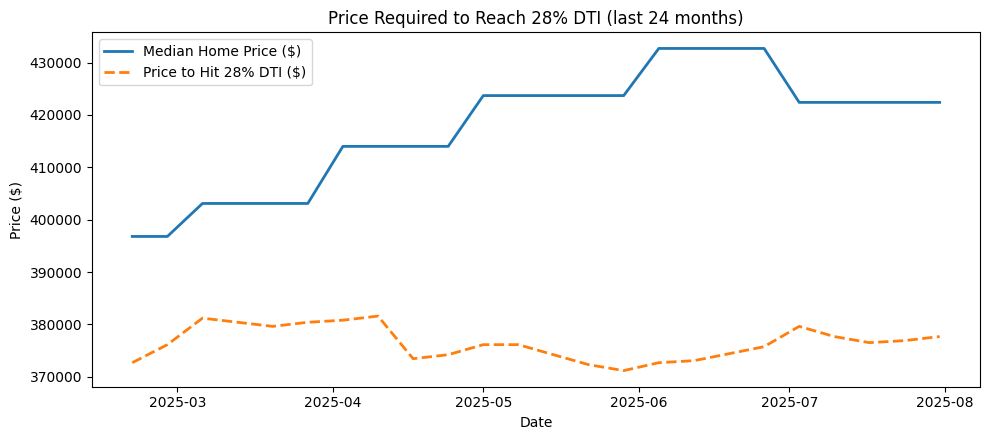

In [19]:
# --- Load Excel with monthly median existing home prices ---
EXCEL_FILE = "/Users/ndilawari/Documents/Python/Home Affordability/median home prices.xlsx"   # update path
DATE_COL   = "Date"                                        # update if named differently
PRICE_COL  = "Median Home Price"                  # update if named differently

hp = pd.read_excel(EXCEL_FILE)
hp[DATE_COL] = pd.to_datetime(hp[DATE_COL])
hp = hp[[DATE_COL, PRICE_COL]].sort_values(DATE_COL).set_index(DATE_COL)

# Stop at July 2025
hp = hp.loc[: "2025-07-31"]

# Align with df index (which has mortgage_rate + income)
df = df.copy()
df = df.loc[: "2025-07-31"]   # cut main df to July 2025 as well
df["median_home_price"] = hp.reindex(df.index, method="ffill")[PRICE_COL]

# --- Function: price that makes payment = target % of income ---
def price_for_target_payment(rate_annual, target_payment, down_pct=0.20, term_years=30):
    r = (rate_annual/100)/12
    n = term_years*12
    if r == 0:
        L = target_payment * n
    else:
        ann = (r*(1+r)**n) / ((1+r)**n - 1)
        L = target_payment / ann
    return L / (1 - down_pct)

# Ensure we have monthly income
if "income_monthly" not in df.columns:
    df["income_monthly"] = df["household_income"] / 12.0

# Target DTI
target_pct = 0.28
df["price_to_qualify_28pct"] = df.apply(
    lambda r: price_for_target_payment(r["mortgage_rate"], target_pct*r["income_monthly"]),
    axis=1
)

# --- Stats for July 2025 ---
latest_row = df.dropna(subset=["median_home_price","price_to_qualify_28pct"]).iloc[-1]
price_now  = float(latest_row["median_home_price"])
price_need = float(latest_row["price_to_qualify_28pct"])
cut_dollar = price_now - price_need
cut_pct    = 100 * cut_dollar / price_now

print(f"As of {latest_row.name.strftime('%b %Y')}, at rate {latest_row['mortgage_rate']:.2f}%: "
      f"Price would need to be ${price_need:,.0f} for 28% DTI "
      f"(vs current ${price_now:,.0f}). "
      f"That implies a ${cut_dollar:,.0f} cut ({cut_pct:.1f}%).")

# --- Plot last 24 months: actual vs price needed ---
last24 = df.iloc[-24:]
plt.figure(figsize=(10,4.5))
plt.plot(last24.index, last24["median_home_price"], linewidth=2, label="Median Home Price ($)")
plt.plot(last24.index, last24["price_to_qualify_28pct"], linewidth=2, linestyle="--", label="Price to Hit 28% DTI ($)")
plt.title("Price Required to Reach 28% DTI (last 24 months)")
plt.ylabel("Price ($)"); plt.xlabel("Date")
plt.legend(); plt.tight_layout(); plt.show()

In [20]:

# Build dataset
reg_df = df.loc["2019-01-01":].dropna(subset=["monthly_payment_baseline", "median_home_price", "mortgage_rate"]).copy()
X = reg_df[["median_home_price", "mortgage_rate"]]
y = reg_df["monthly_payment_baseline"]

# Add constant
X = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X).fit()
print(model.summary())

# Decomposition: how much of the change since 2019 is due to each factor?
first = reg_df.iloc[0]
last  = reg_df.iloc[-1]

delta_payment = last["monthly_payment_baseline"] - first["monthly_payment_baseline"]
delta_price   = (last["median_home_price"] - first["median_home_price"]) * model.params["median_home_price"]
delta_rate    = (last["mortgage_rate"] - first["mortgage_rate"]) * model.params["mortgage_rate"]

share_price = delta_price / delta_payment * 100
share_rate  = delta_rate / delta_payment * 100

print(f"Change in avg monthly payment since Jan 2019: ${delta_payment:,.0f}")
print(f"Attributable to home prices: {share_price:.1f}%")
print(f"Attributable to mortgage rates: {share_rate:.1f}%")

                               OLS Regression Results                               
Dep. Variable:     monthly_payment_baseline   R-squared:                       0.978
Model:                                  OLS   Adj. R-squared:                  0.978
Method:                       Least Squares   F-statistic:                     7480.
Date:                      Wed, 24 Sep 2025   Prob (F-statistic):          2.19e-282
Time:                              14:47:02   Log-Likelihood:                -1958.9
No. Observations:                       344   AIC:                             3924.
Df Residuals:                           341   BIC:                             3935.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [22]:
print("""The regression model explains 97.8% of the variation in monthly mortgage payments, with both home prices and mortgage rates having statistically significant effects. Since January 2019, the average monthly payment increased by $855, with 56.1% of the rise due to 
      home prices and 54.7% due to mortgage rates.""")

The regression model explains 97.8% of the variation in monthly mortgage payments, with both home prices and mortgage rates having statistically significant effects. Since January 2019, the average monthly payment increased by $855, with 56.1% of the rise due to 
      home prices and 54.7% due to mortgage rates.
